# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

## Project
---

Install packages that are not part of the basic virtual environment defined on the ReadMe.

Import relevant packages

In [1]:
from datasets import load_dataset, Audio,DatasetDict
import numpy as np
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer,AutoConfig
import evaluate
import torch
import gc
from sklearn import metrics
import matplotlib.pyplot as plt

c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Get gtzan audio files and their corresponding labels from the Hugging Face Hub and split the dataset into training, validation and test sets.

In [2]:
gtzan = load_dataset("marsyas/gtzan", "all",trust_remote_code=True)
train_rest = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.2)
val_test = train_rest["test"].train_test_split(seed=42, shuffle=True, test_size=0.5)
gtzan=DatasetDict({'train': train_rest["train"],'val': val_test["train"],'test': val_test["test"]})

Get AST feature extractor which: 
1. Extracts mel-filter bank features from raw speech.
2. Pads/truncates the features to a fixed length.
3. Normalizes the features(Substracting mean and dividing by the standard deviation).

In [3]:
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

Resample the dataset according to the pretrained AST sample rate.

In [4]:
sampling_rate = feature_extractor.sampling_rate
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

Apply AST feature extractor to the dataset. 

In [5]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)

Obtain the label mappings from the dataset.

In [16]:
id2label_fn = gtzan["train"].features["genre"].int2str
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")
id2label = {
    i: id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

Create accuracy calculation function. 

In [17]:
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Get, adjust and train the AST pretrained model.

In [18]:
gc.collect()
torch.cuda.empty_cache()
#Get pretrained model
model = AutoModelForAudioClassification.from_pretrained(model_id)
model.config=AutoConfig.from_pretrained(model_id)
#Adjust model
num_labels = len(id2label)
model.num_labels=num_labels
model.config.num_labels = num_labels
model.config.id2label=id2label
model.config.label2id=label2id
model.requires_grad_(False)
model.classifier.dense= torch.nn.Linear(model.classifier.dense.in_features,num_labels)
#Define hyperparameters
model_name = model_id.split("/")[-1]
batch_size = 64
gradient_accumulation_steps = 1
num_train_epochs = 50
training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    save_total_limit=5,
    report_to='tensorboard',
)
#Train model
trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"].with_format("torch"),
    eval_dataset=gtzan_encoded["val"].with_format("torch"),
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
train_results =trainer.train()
trainer.save_model('Best_Model')

c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  0%|          | 0/650 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\transformers\models\audio_spectrogram_transformer\modeling_audio_spectrogram_transformer.py:187: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
  1%|          | 5/650 [00:16<33:54,  3.15s/it]

{'loss': 2.3671, 'grad_norm': 6.464977264404297, 'learning_rate': 3.846153846153847e-06, 'epoch': 0.38}


  2%|▏         | 10/650 [00:32<30:32,  2.86s/it]

{'loss': 2.3744, 'grad_norm': 6.938712120056152, 'learning_rate': 7.692307692307694e-06, 'epoch': 0.77}


                                                
  2%|▏         | 13/650 [00:40<19:59,  1.88s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.3569676876068115, 'eval_accuracy': 0.13, 'eval_runtime': 3.3099, 'eval_samples_per_second': 30.212, 'eval_steps_per_second': 0.604, 'epoch': 1.0}


  2%|▏         | 15/650 [00:49<38:16,  3.62s/it]

{'loss': 2.4346, 'grad_norm': 6.1156792640686035, 'learning_rate': 1.153846153846154e-05, 'epoch': 1.15}


  3%|▎         | 20/650 [01:02<30:39,  2.92s/it]

{'loss': 2.3618, 'grad_norm': 5.470927715301514, 'learning_rate': 1.5384615384615387e-05, 'epoch': 1.54}


  4%|▍         | 25/650 [01:16<26:47,  2.57s/it]

{'loss': 2.3036, 'grad_norm': 6.557686805725098, 'learning_rate': 1.923076923076923e-05, 'epoch': 1.92}


                                                
  4%|▍         | 26/650 [01:21<20:58,  2.02s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.308603525161743, 'eval_accuracy': 0.14, 'eval_runtime': 4.7134, 'eval_samples_per_second': 21.216, 'eval_steps_per_second': 0.424, 'epoch': 2.0}


  5%|▍         | 30/650 [01:35<34:32,  3.34s/it]

{'loss': 2.3386, 'grad_norm': 5.028924465179443, 'learning_rate': 2.307692307692308e-05, 'epoch': 2.31}


  5%|▌         | 35/650 [01:49<29:40,  2.89s/it]

{'loss': 2.275, 'grad_norm': 6.393089294433594, 'learning_rate': 2.6923076923076923e-05, 'epoch': 2.69}


                                                
  6%|▌         | 39/650 [02:01<20:39,  2.03s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.2317285537719727, 'eval_accuracy': 0.15, 'eval_runtime': 4.5368, 'eval_samples_per_second': 22.042, 'eval_steps_per_second': 0.441, 'epoch': 3.0}


  6%|▌         | 40/650 [02:07<46:28,  4.57s/it]

{'loss': 2.2725, 'grad_norm': 5.672514915466309, 'learning_rate': 3.0769230769230774e-05, 'epoch': 3.08}


  7%|▋         | 45/650 [02:21<31:16,  3.10s/it]

{'loss': 2.2141, 'grad_norm': 5.507002830505371, 'learning_rate': 3.461538461538462e-05, 'epoch': 3.46}


  8%|▊         | 50/650 [02:35<28:37,  2.86s/it]

{'loss': 2.2214, 'grad_norm': 5.395743370056152, 'learning_rate': 3.846153846153846e-05, 'epoch': 3.85}


                                                
  8%|▊         | 52/650 [02:43<21:13,  2.13s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.134589910507202, 'eval_accuracy': 0.17, 'eval_runtime': 4.6486, 'eval_samples_per_second': 21.512, 'eval_steps_per_second': 0.43, 'epoch': 4.0}


  8%|▊         | 55/650 [02:51<29:58,  3.02s/it]

{'loss': 2.1143, 'grad_norm': 5.2135114669799805, 'learning_rate': 4.230769230769231e-05, 'epoch': 4.23}


  9%|▉         | 60/650 [03:05<28:34,  2.91s/it]

{'loss': 2.0758, 'grad_norm': 4.518222808837891, 'learning_rate': 4.615384615384616e-05, 'epoch': 4.62}


 10%|█         | 65/650 [03:17<20:39,  2.12s/it]

{'loss': 2.0212, 'grad_norm': 7.243997573852539, 'learning_rate': 5e-05, 'epoch': 5.0}


                                                
 10%|█         | 65/650 [03:22<20:39,  2.12s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.014638662338257, 'eval_accuracy': 0.25, 'eval_runtime': 4.8081, 'eval_samples_per_second': 20.798, 'eval_steps_per_second': 0.416, 'epoch': 5.0}


 11%|█         | 70/650 [03:39<31:56,  3.30s/it]

{'loss': 2.0024, 'grad_norm': 5.550307750701904, 'learning_rate': 4.9572649572649575e-05, 'epoch': 5.38}


 12%|█▏        | 75/650 [03:54<29:17,  3.06s/it]

{'loss': 1.9385, 'grad_norm': 4.348957061767578, 'learning_rate': 4.9145299145299147e-05, 'epoch': 5.77}


                                                
 12%|█▏        | 78/650 [04:04<20:41,  2.17s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.8999512195587158, 'eval_accuracy': 0.36, 'eval_runtime': 4.8132, 'eval_samples_per_second': 20.776, 'eval_steps_per_second': 0.416, 'epoch': 6.0}


 12%|█▏        | 80/650 [04:14<42:16,  4.45s/it]

{'loss': 1.8992, 'grad_norm': 5.095742702484131, 'learning_rate': 4.871794871794872e-05, 'epoch': 6.15}


 13%|█▎        | 85/650 [04:29<30:04,  3.19s/it]

{'loss': 1.836, 'grad_norm': 4.434849262237549, 'learning_rate': 4.829059829059829e-05, 'epoch': 6.54}


 14%|█▍        | 90/650 [04:43<25:40,  2.75s/it]

{'loss': 1.7942, 'grad_norm': 4.694981098175049, 'learning_rate': 4.786324786324787e-05, 'epoch': 6.92}


                                                
 14%|█▍        | 91/650 [04:49<20:13,  2.17s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.7911964654922485, 'eval_accuracy': 0.47, 'eval_runtime': 4.7817, 'eval_samples_per_second': 20.913, 'eval_steps_per_second': 0.418, 'epoch': 7.0}


 15%|█▍        | 95/650 [05:04<32:47,  3.55s/it]

{'loss': 1.7444, 'grad_norm': 4.8652143478393555, 'learning_rate': 4.7435897435897435e-05, 'epoch': 7.31}


 15%|█▌        | 100/650 [05:18<27:46,  3.03s/it]

{'loss': 1.7203, 'grad_norm': 4.461526870727539, 'learning_rate': 4.700854700854701e-05, 'epoch': 7.69}


                                                 
 16%|█▌        | 104/650 [05:32<19:36,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.6919822692871094, 'eval_accuracy': 0.58, 'eval_runtime': 4.6687, 'eval_samples_per_second': 21.419, 'eval_steps_per_second': 0.428, 'epoch': 8.0}


 16%|█▌        | 105/650 [05:37<41:34,  4.58s/it]

{'loss': 1.6386, 'grad_norm': 4.433168888092041, 'learning_rate': 4.6581196581196586e-05, 'epoch': 8.08}


 17%|█▋        | 110/650 [05:54<29:57,  3.33s/it]

{'loss': 1.6537, 'grad_norm': 3.99312686920166, 'learning_rate': 4.615384615384616e-05, 'epoch': 8.46}


 18%|█▊        | 115/650 [06:09<27:15,  3.06s/it]

{'loss': 1.589, 'grad_norm': 4.726227760314941, 'learning_rate': 4.572649572649573e-05, 'epoch': 8.85}


                                                 
 18%|█▊        | 117/650 [06:17<19:24,  2.18s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.6003613471984863, 'eval_accuracy': 0.62, 'eval_runtime': 4.8448, 'eval_samples_per_second': 20.641, 'eval_steps_per_second': 0.413, 'epoch': 9.0}


 18%|█▊        | 120/650 [06:29<33:39,  3.81s/it]

{'loss': 1.5904, 'grad_norm': 4.1744914054870605, 'learning_rate': 4.52991452991453e-05, 'epoch': 9.23}


 19%|█▉        | 125/650 [06:44<27:17,  3.12s/it]

{'loss': 1.5308, 'grad_norm': 4.524899959564209, 'learning_rate': 4.4871794871794874e-05, 'epoch': 9.62}


 20%|██        | 130/650 [06:56<18:40,  2.16s/it]

{'loss': 1.4755, 'grad_norm': 4.567501544952393, 'learning_rate': 4.4444444444444447e-05, 'epoch': 10.0}


                                                 
 20%|██        | 130/650 [07:00<18:40,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.5215039253234863, 'eval_accuracy': 0.62, 'eval_runtime': 4.8344, 'eval_samples_per_second': 20.685, 'eval_steps_per_second': 0.414, 'epoch': 10.0}


 21%|██        | 135/650 [07:16<24:57,  2.91s/it]

{'loss': 1.467, 'grad_norm': 4.510563850402832, 'learning_rate': 4.401709401709402e-05, 'epoch': 10.38}


 22%|██▏       | 140/650 [07:29<24:06,  2.84s/it]

{'loss': 1.397, 'grad_norm': 4.502652168273926, 'learning_rate': 4.358974358974359e-05, 'epoch': 10.77}


                                                 
 22%|██▏       | 143/650 [07:41<19:33,  2.32s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.4501221179962158, 'eval_accuracy': 0.64, 'eval_runtime': 4.6515, 'eval_samples_per_second': 21.498, 'eval_steps_per_second': 0.43, 'epoch': 11.0}


 22%|██▏       | 145/650 [07:50<34:46,  4.13s/it]

{'loss': 1.4046, 'grad_norm': 3.851041316986084, 'learning_rate': 4.316239316239317e-05, 'epoch': 11.15}


 23%|██▎       | 150/650 [08:04<25:57,  3.11s/it]

{'loss': 1.4375, 'grad_norm': 3.6484503746032715, 'learning_rate': 4.2735042735042735e-05, 'epoch': 11.54}


 24%|██▍       | 155/650 [08:18<22:37,  2.74s/it]

{'loss': 1.2934, 'grad_norm': 4.359030246734619, 'learning_rate': 4.230769230769231e-05, 'epoch': 11.92}


                                                 
 24%|██▍       | 156/650 [08:24<17:41,  2.15s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.3818820714950562, 'eval_accuracy': 0.66, 'eval_runtime': 4.9208, 'eval_samples_per_second': 20.322, 'eval_steps_per_second': 0.406, 'epoch': 12.0}


 25%|██▍       | 160/650 [08:39<28:49,  3.53s/it]

{'loss': 1.2859, 'grad_norm': 3.6109426021575928, 'learning_rate': 4.1880341880341886e-05, 'epoch': 12.31}


 25%|██▌       | 165/650 [08:53<24:26,  3.02s/it]

{'loss': 1.3234, 'grad_norm': 3.255286455154419, 'learning_rate': 4.145299145299146e-05, 'epoch': 12.69}


                                                 
 26%|██▌       | 169/650 [09:07<17:23,  2.17s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.3214011192321777, 'eval_accuracy': 0.68, 'eval_runtime': 4.7576, 'eval_samples_per_second': 21.019, 'eval_steps_per_second': 0.42, 'epoch': 13.0}


 26%|██▌       | 170/650 [09:12<35:50,  4.48s/it]

{'loss': 1.1961, 'grad_norm': 3.619797945022583, 'learning_rate': 4.1025641025641023e-05, 'epoch': 13.08}


 27%|██▋       | 175/650 [09:27<25:20,  3.20s/it]

{'loss': 1.2365, 'grad_norm': 3.7294487953186035, 'learning_rate': 4.05982905982906e-05, 'epoch': 13.46}


 28%|██▊       | 180/650 [09:41<23:25,  2.99s/it]

{'loss': 1.2226, 'grad_norm': 3.4990336894989014, 'learning_rate': 4.0170940170940174e-05, 'epoch': 13.85}


                                                 
 28%|██▊       | 182/650 [09:50<17:25,  2.23s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.263159155845642, 'eval_accuracy': 0.69, 'eval_runtime': 4.818, 'eval_samples_per_second': 20.756, 'eval_steps_per_second': 0.415, 'epoch': 14.0}


 28%|██▊       | 185/650 [10:01<29:05,  3.75s/it]

{'loss': 1.2207, 'grad_norm': 4.232944488525391, 'learning_rate': 3.974358974358974e-05, 'epoch': 14.23}


 29%|██▉       | 190/650 [10:14<21:54,  2.86s/it]

{'loss': 1.1651, 'grad_norm': 3.947817325592041, 'learning_rate': 3.931623931623932e-05, 'epoch': 14.62}


 30%|███       | 195/650 [10:25<16:13,  2.14s/it]

{'loss': 1.1214, 'grad_norm': 4.013233661651611, 'learning_rate': 3.888888888888889e-05, 'epoch': 15.0}


                                                 
 30%|███       | 195/650 [10:32<16:13,  2.14s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.2133008241653442, 'eval_accuracy': 0.7, 'eval_runtime': 6.7899, 'eval_samples_per_second': 14.728, 'eval_steps_per_second': 0.295, 'epoch': 15.0}


 31%|███       | 200/650 [10:49<25:46,  3.44s/it]

{'loss': 1.1146, 'grad_norm': 3.0426056385040283, 'learning_rate': 3.846153846153846e-05, 'epoch': 15.38}


 32%|███▏      | 205/650 [11:05<22:58,  3.10s/it]

{'loss': 1.1421, 'grad_norm': 4.459449768066406, 'learning_rate': 3.8034188034188035e-05, 'epoch': 15.77}


                                                 
 32%|███▏      | 208/650 [11:14<16:25,  2.23s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.169826626777649, 'eval_accuracy': 0.71, 'eval_runtime': 3.3527, 'eval_samples_per_second': 29.826, 'eval_steps_per_second': 0.597, 'epoch': 16.0}


 32%|███▏      | 210/650 [11:20<22:43,  3.10s/it]

{'loss': 1.0954, 'grad_norm': 3.2740097045898438, 'learning_rate': 3.760683760683761e-05, 'epoch': 16.15}


 33%|███▎      | 215/650 [11:33<20:32,  2.83s/it]

{'loss': 1.0846, 'grad_norm': 3.109940767288208, 'learning_rate': 3.717948717948718e-05, 'epoch': 16.54}


 34%|███▍      | 220/650 [11:47<18:59,  2.65s/it]

{'loss': 1.0364, 'grad_norm': 3.7636349201202393, 'learning_rate': 3.675213675213676e-05, 'epoch': 16.92}


                                                 
 34%|███▍      | 221/650 [11:52<14:56,  2.09s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.1281079053878784, 'eval_accuracy': 0.72, 'eval_runtime': 4.644, 'eval_samples_per_second': 21.533, 'eval_steps_per_second': 0.431, 'epoch': 17.0}


 35%|███▍      | 225/650 [12:06<23:46,  3.36s/it]

{'loss': 1.1106, 'grad_norm': 3.154494047164917, 'learning_rate': 3.6324786324786323e-05, 'epoch': 17.31}


 35%|███▌      | 230/650 [12:20<20:23,  2.91s/it]

{'loss': 0.9931, 'grad_norm': 2.877903938293457, 'learning_rate': 3.58974358974359e-05, 'epoch': 17.69}


                                                 
 36%|███▌      | 234/650 [12:33<14:38,  2.11s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.0896753072738647, 'eval_accuracy': 0.75, 'eval_runtime': 4.6853, 'eval_samples_per_second': 21.343, 'eval_steps_per_second': 0.427, 'epoch': 18.0}


 36%|███▌      | 235/650 [12:38<29:52,  4.32s/it]

{'loss': 1.0003, 'grad_norm': 3.039487838745117, 'learning_rate': 3.5470085470085474e-05, 'epoch': 18.08}


 37%|███▋      | 240/650 [12:52<20:56,  3.07s/it]

{'loss': 1.0288, 'grad_norm': 2.7279927730560303, 'learning_rate': 3.504273504273504e-05, 'epoch': 18.46}


 38%|███▊      | 245/650 [13:06<19:21,  2.87s/it]

{'loss': 0.9723, 'grad_norm': 4.092679977416992, 'learning_rate': 3.461538461538462e-05, 'epoch': 18.85}


                                                 
 38%|███▊      | 247/650 [13:13<14:08,  2.10s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.0562841892242432, 'eval_accuracy': 0.75, 'eval_runtime': 4.5679, 'eval_samples_per_second': 21.892, 'eval_steps_per_second': 0.438, 'epoch': 19.0}


 38%|███▊      | 250/650 [13:24<23:54,  3.59s/it]

{'loss': 0.9676, 'grad_norm': 3.1465911865234375, 'learning_rate': 3.418803418803419e-05, 'epoch': 19.23}


 39%|███▉      | 255/650 [13:38<19:23,  2.95s/it]

{'loss': 0.9405, 'grad_norm': 2.768277883529663, 'learning_rate': 3.376068376068376e-05, 'epoch': 19.62}


 40%|████      | 260/650 [13:50<13:39,  2.10s/it]

{'loss': 0.9859, 'grad_norm': 3.820427656173706, 'learning_rate': 3.3333333333333335e-05, 'epoch': 20.0}


                                                 
 40%|████      | 260/650 [13:54<13:39,  2.10s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.0290844440460205, 'eval_accuracy': 0.75, 'eval_runtime': 4.7068, 'eval_samples_per_second': 21.246, 'eval_steps_per_second': 0.425, 'epoch': 20.0}


 41%|████      | 265/650 [14:11<20:35,  3.21s/it]

{'loss': 0.9056, 'grad_norm': 3.1485402584075928, 'learning_rate': 3.290598290598291e-05, 'epoch': 20.38}


 42%|████▏     | 270/650 [14:25<18:18,  2.89s/it]

{'loss': 0.9472, 'grad_norm': 2.69245982170105, 'learning_rate': 3.247863247863248e-05, 'epoch': 20.77}


                                                 
 42%|████▏     | 273/650 [14:35<13:05,  2.08s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9993554949760437, 'eval_accuracy': 0.76, 'eval_runtime': 4.6169, 'eval_samples_per_second': 21.66, 'eval_steps_per_second': 0.433, 'epoch': 21.0}


 42%|████▏     | 275/650 [14:43<25:00,  4.00s/it]

{'loss': 0.9394, 'grad_norm': 3.342738389968872, 'learning_rate': 3.205128205128206e-05, 'epoch': 21.15}


 43%|████▎     | 280/650 [15:00<19:54,  3.23s/it]

{'loss': 0.9245, 'grad_norm': 2.8602476119995117, 'learning_rate': 3.162393162393162e-05, 'epoch': 21.54}


 44%|████▍     | 285/650 [15:14<16:35,  2.73s/it]

{'loss': 0.8909, 'grad_norm': 3.1164495944976807, 'learning_rate': 3.1196581196581195e-05, 'epoch': 21.92}


                                                 
 44%|████▍     | 286/650 [15:19<12:57,  2.14s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9752941727638245, 'eval_accuracy': 0.78, 'eval_runtime': 4.7936, 'eval_samples_per_second': 20.861, 'eval_steps_per_second': 0.417, 'epoch': 22.0}


 45%|████▍     | 290/650 [15:33<20:36,  3.43s/it]

{'loss': 0.8671, 'grad_norm': 2.952967643737793, 'learning_rate': 3.0769230769230774e-05, 'epoch': 22.31}


 45%|████▌     | 295/650 [15:48<17:47,  3.01s/it]

{'loss': 0.8816, 'grad_norm': 2.722172498703003, 'learning_rate': 3.034188034188034e-05, 'epoch': 22.69}


                                                 
 46%|████▌     | 299/650 [16:01<12:38,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9526318311691284, 'eval_accuracy': 0.78, 'eval_runtime': 4.7437, 'eval_samples_per_second': 21.081, 'eval_steps_per_second': 0.422, 'epoch': 23.0}


 46%|████▌     | 300/650 [16:06<26:01,  4.46s/it]

{'loss': 0.8945, 'grad_norm': 2.431295156478882, 'learning_rate': 2.9914529914529915e-05, 'epoch': 23.08}


 47%|████▋     | 305/650 [16:21<18:09,  3.16s/it]

{'loss': 0.8455, 'grad_norm': 2.773179531097412, 'learning_rate': 2.948717948717949e-05, 'epoch': 23.46}


 48%|████▊     | 310/650 [16:36<16:49,  2.97s/it]

{'loss': 0.8676, 'grad_norm': 2.9965479373931885, 'learning_rate': 2.9059829059829063e-05, 'epoch': 23.85}


                                                 
 48%|████▊     | 312/650 [16:43<12:16,  2.18s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9300525188446045, 'eval_accuracy': 0.79, 'eval_runtime': 4.7381, 'eval_samples_per_second': 21.105, 'eval_steps_per_second': 0.422, 'epoch': 24.0}


 48%|████▊     | 315/650 [16:54<20:35,  3.69s/it]

{'loss': 0.8636, 'grad_norm': 2.735218048095703, 'learning_rate': 2.863247863247863e-05, 'epoch': 24.23}


 49%|████▉     | 320/650 [17:10<17:02,  3.10s/it]

{'loss': 0.8444, 'grad_norm': 2.6655728816986084, 'learning_rate': 2.8205128205128207e-05, 'epoch': 24.62}


 50%|█████     | 325/650 [17:21<11:37,  2.15s/it]

{'loss': 0.7986, 'grad_norm': 4.1996307373046875, 'learning_rate': 2.777777777777778e-05, 'epoch': 25.0}


                                                 
 50%|█████     | 325/650 [17:27<11:37,  2.15s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9109655618667603, 'eval_accuracy': 0.78, 'eval_runtime': 5.9033, 'eval_samples_per_second': 16.94, 'eval_steps_per_second': 0.339, 'epoch': 25.0}


 51%|█████     | 330/650 [17:44<18:13,  3.42s/it]

{'loss': 0.8347, 'grad_norm': 2.780423641204834, 'learning_rate': 2.7350427350427355e-05, 'epoch': 25.38}


 52%|█████▏    | 335/650 [17:57<14:04,  2.68s/it]

{'loss': 0.7954, 'grad_norm': 2.8035879135131836, 'learning_rate': 2.6923076923076923e-05, 'epoch': 25.77}


                                                 
 52%|█████▏    | 338/650 [18:09<12:04,  2.32s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8921765685081482, 'eval_accuracy': 0.79, 'eval_runtime': 4.7044, 'eval_samples_per_second': 21.257, 'eval_steps_per_second': 0.425, 'epoch': 26.0}


 52%|█████▏    | 340/650 [18:18<21:14,  4.11s/it]

{'loss': 0.8259, 'grad_norm': 2.96799635887146, 'learning_rate': 2.64957264957265e-05, 'epoch': 26.15}


 53%|█████▎    | 345/650 [18:34<16:26,  3.24s/it]

{'loss': 0.8018, 'grad_norm': 2.250802755355835, 'learning_rate': 2.606837606837607e-05, 'epoch': 26.54}


 54%|█████▍    | 350/650 [18:48<13:55,  2.79s/it]

{'loss': 0.7798, 'grad_norm': 2.350506544113159, 'learning_rate': 2.564102564102564e-05, 'epoch': 26.92}


                                                 
 54%|█████▍    | 351/650 [18:54<10:50,  2.18s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8765478730201721, 'eval_accuracy': 0.79, 'eval_runtime': 4.7836, 'eval_samples_per_second': 20.905, 'eval_steps_per_second': 0.418, 'epoch': 27.0}


 55%|█████▍    | 355/650 [19:08<16:58,  3.45s/it]

{'loss': 0.7652, 'grad_norm': 2.821380138397217, 'learning_rate': 2.5213675213675215e-05, 'epoch': 27.31}


 55%|█████▌    | 360/650 [19:24<15:11,  3.14s/it]

{'loss': 0.8154, 'grad_norm': 3.1163175106048584, 'learning_rate': 2.4786324786324787e-05, 'epoch': 27.69}


                                                 
 56%|█████▌    | 364/650 [19:38<10:19,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.861157238483429, 'eval_accuracy': 0.79, 'eval_runtime': 4.7672, 'eval_samples_per_second': 20.977, 'eval_steps_per_second': 0.42, 'epoch': 28.0}


 56%|█████▌    | 365/650 [19:43<21:19,  4.49s/it]

{'loss': 0.8164, 'grad_norm': 2.753244638442993, 'learning_rate': 2.435897435897436e-05, 'epoch': 28.08}


 57%|█████▋    | 370/650 [19:59<15:24,  3.30s/it]

{'loss': 0.7345, 'grad_norm': 3.0803322792053223, 'learning_rate': 2.3931623931623935e-05, 'epoch': 28.46}


 58%|█████▊    | 375/650 [20:14<13:52,  3.03s/it]

{'loss': 0.7741, 'grad_norm': 2.525054454803467, 'learning_rate': 2.3504273504273504e-05, 'epoch': 28.85}


                                                 
 58%|█████▊    | 377/650 [20:22<10:17,  2.26s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8493414521217346, 'eval_accuracy': 0.8, 'eval_runtime': 4.7351, 'eval_samples_per_second': 21.119, 'eval_steps_per_second': 0.422, 'epoch': 29.0}


 58%|█████▊    | 380/650 [20:33<16:41,  3.71s/it]

{'loss': 0.7315, 'grad_norm': 2.2459909915924072, 'learning_rate': 2.307692307692308e-05, 'epoch': 29.23}


 59%|█████▉    | 385/650 [20:48<13:46,  3.12s/it]

{'loss': 0.7457, 'grad_norm': 2.3318660259246826, 'learning_rate': 2.264957264957265e-05, 'epoch': 29.62}


 60%|██████    | 390/650 [21:00<09:19,  2.15s/it]

{'loss': 0.7785, 'grad_norm': 3.8494338989257812, 'learning_rate': 2.2222222222222223e-05, 'epoch': 30.0}


                                                 
 60%|██████    | 390/650 [21:05<09:19,  2.15s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8361157774925232, 'eval_accuracy': 0.8, 'eval_runtime': 4.7831, 'eval_samples_per_second': 20.907, 'eval_steps_per_second': 0.418, 'epoch': 30.0}


 61%|██████    | 395/650 [21:22<14:06,  3.32s/it]

{'loss': 0.7685, 'grad_norm': 2.6697776317596436, 'learning_rate': 2.1794871794871795e-05, 'epoch': 30.38}


 62%|██████▏   | 400/650 [21:37<12:28,  2.99s/it]

{'loss': 0.7247, 'grad_norm': 2.437879800796509, 'learning_rate': 2.1367521367521368e-05, 'epoch': 30.77}


                                                 
 62%|██████▏   | 403/650 [21:48<08:58,  2.18s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8240594267845154, 'eval_accuracy': 0.8, 'eval_runtime': 4.7701, 'eval_samples_per_second': 20.964, 'eval_steps_per_second': 0.419, 'epoch': 31.0}


 62%|██████▏   | 405/650 [21:56<16:19,  4.00s/it]

{'loss': 0.7086, 'grad_norm': 2.5892856121063232, 'learning_rate': 2.0940170940170943e-05, 'epoch': 31.15}


 63%|██████▎   | 410/650 [22:10<12:26,  3.11s/it]

{'loss': 0.7225, 'grad_norm': 2.3654401302337646, 'learning_rate': 2.0512820512820512e-05, 'epoch': 31.54}


 64%|██████▍   | 415/650 [22:24<10:41,  2.73s/it]

{'loss': 0.7549, 'grad_norm': 2.453538417816162, 'learning_rate': 2.0085470085470087e-05, 'epoch': 31.92}


                                                 
 64%|██████▍   | 416/650 [22:30<08:20,  2.14s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8125263452529907, 'eval_accuracy': 0.8, 'eval_runtime': 4.7684, 'eval_samples_per_second': 20.971, 'eval_steps_per_second': 0.419, 'epoch': 32.0}


 65%|██████▍   | 420/650 [22:43<13:16,  3.46s/it]

{'loss': 0.7243, 'grad_norm': 2.609862804412842, 'learning_rate': 1.965811965811966e-05, 'epoch': 32.31}


 65%|██████▌   | 425/650 [22:58<11:15,  3.00s/it]

{'loss': 0.7085, 'grad_norm': 2.162839651107788, 'learning_rate': 1.923076923076923e-05, 'epoch': 32.69}


                                                 
 66%|██████▌   | 429/650 [23:12<07:57,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8037298321723938, 'eval_accuracy': 0.8, 'eval_runtime': 4.7484, 'eval_samples_per_second': 21.06, 'eval_steps_per_second': 0.421, 'epoch': 33.0}


 66%|██████▌   | 430/650 [23:17<16:26,  4.48s/it]

{'loss': 0.7662, 'grad_norm': 2.977297067642212, 'learning_rate': 1.8803418803418804e-05, 'epoch': 33.08}


 67%|██████▋   | 435/650 [23:32<11:25,  3.19s/it]

{'loss': 0.7619, 'grad_norm': 2.578510284423828, 'learning_rate': 1.837606837606838e-05, 'epoch': 33.46}


 68%|██████▊   | 440/650 [23:46<10:25,  2.98s/it]

{'loss': 0.6439, 'grad_norm': 2.7418673038482666, 'learning_rate': 1.794871794871795e-05, 'epoch': 33.85}


                                                 
 68%|██████▊   | 442/650 [23:54<07:41,  2.22s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7951343655586243, 'eval_accuracy': 0.8, 'eval_runtime': 4.7899, 'eval_samples_per_second': 20.877, 'eval_steps_per_second': 0.418, 'epoch': 34.0}


 68%|██████▊   | 445/650 [24:05<12:40,  3.71s/it]

{'loss': 0.6988, 'grad_norm': 2.222079277038574, 'learning_rate': 1.752136752136752e-05, 'epoch': 34.23}


 69%|██████▉   | 450/650 [24:21<10:21,  3.11s/it]

{'loss': 0.7372, 'grad_norm': 2.3559811115264893, 'learning_rate': 1.7094017094017095e-05, 'epoch': 34.62}


 70%|███████   | 455/650 [24:33<06:58,  2.15s/it]

{'loss': 0.692, 'grad_norm': 3.5375795364379883, 'learning_rate': 1.6666666666666667e-05, 'epoch': 35.0}


                                                 
 70%|███████   | 455/650 [24:38<06:58,  2.15s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7866088151931763, 'eval_accuracy': 0.8, 'eval_runtime': 4.937, 'eval_samples_per_second': 20.255, 'eval_steps_per_second': 0.405, 'epoch': 35.0}


 71%|███████   | 460/650 [24:54<10:28,  3.31s/it]

{'loss': 0.7013, 'grad_norm': 2.3838284015655518, 'learning_rate': 1.623931623931624e-05, 'epoch': 35.38}


 72%|███████▏  | 465/650 [25:09<09:12,  2.99s/it]

{'loss': 0.6889, 'grad_norm': 1.920175552368164, 'learning_rate': 1.581196581196581e-05, 'epoch': 35.77}


                                                 
 72%|███████▏  | 468/650 [25:19<06:28,  2.13s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7798217535018921, 'eval_accuracy': 0.8, 'eval_runtime': 4.7279, 'eval_samples_per_second': 21.151, 'eval_steps_per_second': 0.423, 'epoch': 36.0}


 72%|███████▏  | 470/650 [25:27<11:58,  3.99s/it]

{'loss': 0.7117, 'grad_norm': 1.9713393449783325, 'learning_rate': 1.5384615384615387e-05, 'epoch': 36.15}


 73%|███████▎  | 475/650 [25:44<09:23,  3.22s/it]

{'loss': 0.6571, 'grad_norm': 2.90356183052063, 'learning_rate': 1.4957264957264958e-05, 'epoch': 36.54}


 74%|███████▍  | 480/650 [25:58<07:49,  2.76s/it]

{'loss': 0.6987, 'grad_norm': 2.073471784591675, 'learning_rate': 1.4529914529914531e-05, 'epoch': 36.92}


                                                 
 74%|███████▍  | 481/650 [26:03<06:06,  2.17s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7741020917892456, 'eval_accuracy': 0.8, 'eval_runtime': 4.7924, 'eval_samples_per_second': 20.866, 'eval_steps_per_second': 0.417, 'epoch': 37.0}


 75%|███████▍  | 485/650 [26:17<09:29,  3.45s/it]

{'loss': 0.6983, 'grad_norm': 1.9238156080245972, 'learning_rate': 1.4102564102564104e-05, 'epoch': 37.31}


 75%|███████▌  | 490/650 [26:33<08:13,  3.08s/it]

{'loss': 0.715, 'grad_norm': 2.724382162094116, 'learning_rate': 1.3675213675213677e-05, 'epoch': 37.69}


                                                 
 76%|███████▌  | 494/650 [26:46<05:50,  2.25s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7681939601898193, 'eval_accuracy': 0.8, 'eval_runtime': 3.3117, 'eval_samples_per_second': 30.196, 'eval_steps_per_second': 0.604, 'epoch': 38.0}


 76%|███████▌  | 495/650 [26:49<09:05,  3.52s/it]

{'loss': 0.6696, 'grad_norm': 2.5064427852630615, 'learning_rate': 1.324786324786325e-05, 'epoch': 38.08}


 77%|███████▋  | 500/650 [27:05<07:42,  3.08s/it]

{'loss': 0.6668, 'grad_norm': 2.377807378768921, 'learning_rate': 1.282051282051282e-05, 'epoch': 38.46}


 78%|███████▊  | 505/650 [27:20<07:23,  3.06s/it]

{'loss': 0.6823, 'grad_norm': 1.8841171264648438, 'learning_rate': 1.2393162393162394e-05, 'epoch': 38.85}


                                                 
 78%|███████▊  | 507/650 [27:28<05:04,  2.13s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7629907131195068, 'eval_accuracy': 0.8, 'eval_runtime': 4.7715, 'eval_samples_per_second': 20.958, 'eval_steps_per_second': 0.419, 'epoch': 39.0}


 78%|███████▊  | 510/650 [27:39<08:34,  3.68s/it]

{'loss': 0.6497, 'grad_norm': 2.145495653152466, 'learning_rate': 1.1965811965811967e-05, 'epoch': 39.23}


 79%|███████▉  | 515/650 [27:53<06:54,  3.07s/it]

{'loss': 0.7078, 'grad_norm': 2.683950185775757, 'learning_rate': 1.153846153846154e-05, 'epoch': 39.62}


 80%|████████  | 520/650 [28:07<04:55,  2.27s/it]

{'loss': 0.6624, 'grad_norm': 2.9790945053100586, 'learning_rate': 1.1111111111111112e-05, 'epoch': 40.0}


                                                 
 80%|████████  | 520/650 [28:12<04:55,  2.27s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7583678960800171, 'eval_accuracy': 0.8, 'eval_runtime': 4.8011, 'eval_samples_per_second': 20.828, 'eval_steps_per_second': 0.417, 'epoch': 40.0}


 81%|████████  | 525/650 [28:28<06:53,  3.31s/it]

{'loss': 0.6779, 'grad_norm': 1.9561998844146729, 'learning_rate': 1.0683760683760684e-05, 'epoch': 40.38}


 82%|████████▏ | 530/650 [28:43<05:59,  3.00s/it]

{'loss': 0.6771, 'grad_norm': 1.8870400190353394, 'learning_rate': 1.0256410256410256e-05, 'epoch': 40.77}


                                                 
 82%|████████▏ | 533/650 [28:54<04:16,  2.19s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7544580101966858, 'eval_accuracy': 0.8, 'eval_runtime': 4.8297, 'eval_samples_per_second': 20.705, 'eval_steps_per_second': 0.414, 'epoch': 41.0}


 82%|████████▏ | 535/650 [29:01<07:01,  3.66s/it]

{'loss': 0.6706, 'grad_norm': 2.1574864387512207, 'learning_rate': 9.82905982905983e-06, 'epoch': 41.15}


 83%|████████▎ | 540/650 [29:11<04:21,  2.38s/it]

{'loss': 0.6426, 'grad_norm': 2.4103634357452393, 'learning_rate': 9.401709401709402e-06, 'epoch': 41.54}


 84%|████████▍ | 545/650 [29:25<04:34,  2.61s/it]

{'loss': 0.657, 'grad_norm': 1.9803519248962402, 'learning_rate': 8.974358974358976e-06, 'epoch': 41.92}


                                                 
 84%|████████▍ | 546/650 [29:30<03:34,  2.06s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7502515316009521, 'eval_accuracy': 0.8, 'eval_runtime': 4.8121, 'eval_samples_per_second': 20.781, 'eval_steps_per_second': 0.416, 'epoch': 42.0}


 85%|████████▍ | 550/650 [29:44<05:43,  3.43s/it]

{'loss': 0.6905, 'grad_norm': 2.252779722213745, 'learning_rate': 8.547008547008548e-06, 'epoch': 42.31}


 85%|████████▌ | 555/650 [29:59<04:45,  3.00s/it]

{'loss': 0.6615, 'grad_norm': 2.2844066619873047, 'learning_rate': 8.11965811965812e-06, 'epoch': 42.69}


                                                 
 86%|████████▌ | 559/650 [30:12<03:15,  2.15s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7474830150604248, 'eval_accuracy': 0.8, 'eval_runtime': 4.6791, 'eval_samples_per_second': 21.372, 'eval_steps_per_second': 0.427, 'epoch': 43.0}


 86%|████████▌ | 560/650 [30:17<06:41,  4.46s/it]

{'loss': 0.6454, 'grad_norm': 2.466912269592285, 'learning_rate': 7.692307692307694e-06, 'epoch': 43.08}


 87%|████████▋ | 565/650 [30:32<04:28,  3.16s/it]

{'loss': 0.6661, 'grad_norm': 2.802781105041504, 'learning_rate': 7.264957264957266e-06, 'epoch': 43.46}


 88%|████████▊ | 570/650 [30:47<03:59,  2.99s/it]

{'loss': 0.6269, 'grad_norm': 2.1940910816192627, 'learning_rate': 6.837606837606839e-06, 'epoch': 43.85}


                                                 
 88%|████████▊ | 572/650 [30:55<02:50,  2.19s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7451469898223877, 'eval_accuracy': 0.8, 'eval_runtime': 4.7501, 'eval_samples_per_second': 21.052, 'eval_steps_per_second': 0.421, 'epoch': 44.0}


 88%|████████▊ | 575/650 [31:06<04:37,  3.70s/it]

{'loss': 0.7256, 'grad_norm': 2.5280020236968994, 'learning_rate': 6.41025641025641e-06, 'epoch': 44.23}


 89%|████████▉ | 580/650 [31:20<03:31,  3.02s/it]

{'loss': 0.6411, 'grad_norm': 2.500004768371582, 'learning_rate': 5.982905982905984e-06, 'epoch': 44.62}


 90%|█████████ | 585/650 [31:32<02:20,  2.16s/it]

{'loss': 0.6215, 'grad_norm': 3.0047245025634766, 'learning_rate': 5.555555555555556e-06, 'epoch': 45.0}


                                                 
 90%|█████████ | 585/650 [31:38<02:20,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7429468035697937, 'eval_accuracy': 0.8, 'eval_runtime': 6.4064, 'eval_samples_per_second': 15.609, 'eval_steps_per_second': 0.312, 'epoch': 45.0}


 91%|█████████ | 590/650 [31:55<03:26,  3.44s/it]

{'loss': 0.6504, 'grad_norm': 2.192857503890991, 'learning_rate': 5.128205128205128e-06, 'epoch': 45.38}


 92%|█████████▏| 595/650 [32:10<02:44,  3.00s/it]

{'loss': 0.6566, 'grad_norm': 2.131976842880249, 'learning_rate': 4.700854700854701e-06, 'epoch': 45.77}


                                                 
 92%|█████████▏| 598/650 [32:21<01:52,  2.17s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7409284114837646, 'eval_accuracy': 0.8, 'eval_runtime': 4.7805, 'eval_samples_per_second': 20.918, 'eval_steps_per_second': 0.418, 'epoch': 46.0}


 92%|█████████▏| 600/650 [32:29<03:22,  4.06s/it]

{'loss': 0.6624, 'grad_norm': 2.3856914043426514, 'learning_rate': 4.273504273504274e-06, 'epoch': 46.15}


 93%|█████████▎| 605/650 [32:44<02:19,  3.09s/it]

{'loss': 0.6191, 'grad_norm': 2.0199508666992188, 'learning_rate': 3.846153846153847e-06, 'epoch': 46.54}


 94%|█████████▍| 610/650 [32:58<01:51,  2.79s/it]

{'loss': 0.6856, 'grad_norm': 1.7137531042099, 'learning_rate': 3.4188034188034193e-06, 'epoch': 46.92}


                                                 
 94%|█████████▍| 611/650 [33:04<01:25,  2.19s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7391852736473083, 'eval_accuracy': 0.8, 'eval_runtime': 4.7669, 'eval_samples_per_second': 20.978, 'eval_steps_per_second': 0.42, 'epoch': 47.0}


 95%|█████████▍| 615/650 [33:18<02:00,  3.45s/it]

{'loss': 0.649, 'grad_norm': 1.7657463550567627, 'learning_rate': 2.991452991452992e-06, 'epoch': 47.31}


 95%|█████████▌| 620/650 [33:32<01:30,  3.02s/it]

{'loss': 0.6804, 'grad_norm': 2.1223180294036865, 'learning_rate': 2.564102564102564e-06, 'epoch': 47.69}


                                                 
 96%|█████████▌| 624/650 [33:46<00:55,  2.15s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7382122874259949, 'eval_accuracy': 0.8, 'eval_runtime': 4.7515, 'eval_samples_per_second': 21.046, 'eval_steps_per_second': 0.421, 'epoch': 48.0}


 96%|█████████▌| 625/650 [33:51<01:51,  4.47s/it]

{'loss': 0.6136, 'grad_norm': 2.057129144668579, 'learning_rate': 2.136752136752137e-06, 'epoch': 48.08}


 97%|█████████▋| 630/650 [34:06<01:03,  3.17s/it]

{'loss': 0.6544, 'grad_norm': 2.1384739875793457, 'learning_rate': 1.7094017094017097e-06, 'epoch': 48.46}


 98%|█████████▊| 635/650 [34:20<00:44,  2.98s/it]

{'loss': 0.664, 'grad_norm': 2.2293262481689453, 'learning_rate': 1.282051282051282e-06, 'epoch': 48.85}


                                                 
 98%|█████████▊| 637/650 [34:29<00:30,  2.32s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7376629710197449, 'eval_accuracy': 0.8, 'eval_runtime': 4.7727, 'eval_samples_per_second': 20.952, 'eval_steps_per_second': 0.419, 'epoch': 49.0}


 98%|█████████▊| 640/650 [34:40<00:37,  3.74s/it]

{'loss': 0.6074, 'grad_norm': 2.4988417625427246, 'learning_rate': 8.547008547008548e-07, 'epoch': 49.23}


 99%|█████████▉| 645/650 [34:56<00:15,  3.13s/it]

{'loss': 0.6961, 'grad_norm': 2.328141689300537, 'learning_rate': 4.273504273504274e-07, 'epoch': 49.62}


100%|██████████| 650/650 [35:08<00:00,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'loss': 0.6217, 'grad_norm': 4.207909107208252, 'learning_rate': 0.0, 'epoch': 50.0}


                                                 
100%|██████████| 650/650 [35:13<00:00,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7373651266098022, 'eval_accuracy': 0.8, 'eval_runtime': 4.6125, 'eval_samples_per_second': 21.68, 'eval_steps_per_second': 0.434, 'epoch': 50.0}


100%|██████████| 650/650 [35:14<00:00,  3.25s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'train_runtime': 2114.1088, 'train_samples_per_second': 18.897, 'train_steps_per_second': 0.307, 'train_loss': 1.0698981325442973, 'epoch': 50.0}


Calculate test metrics

100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


{'test_loss': 0.8057342767715454, 'test_accuracy': 0.83, 'test_runtime': 4.2029, 'test_samples_per_second': 23.793, 'test_steps_per_second': 0.476}


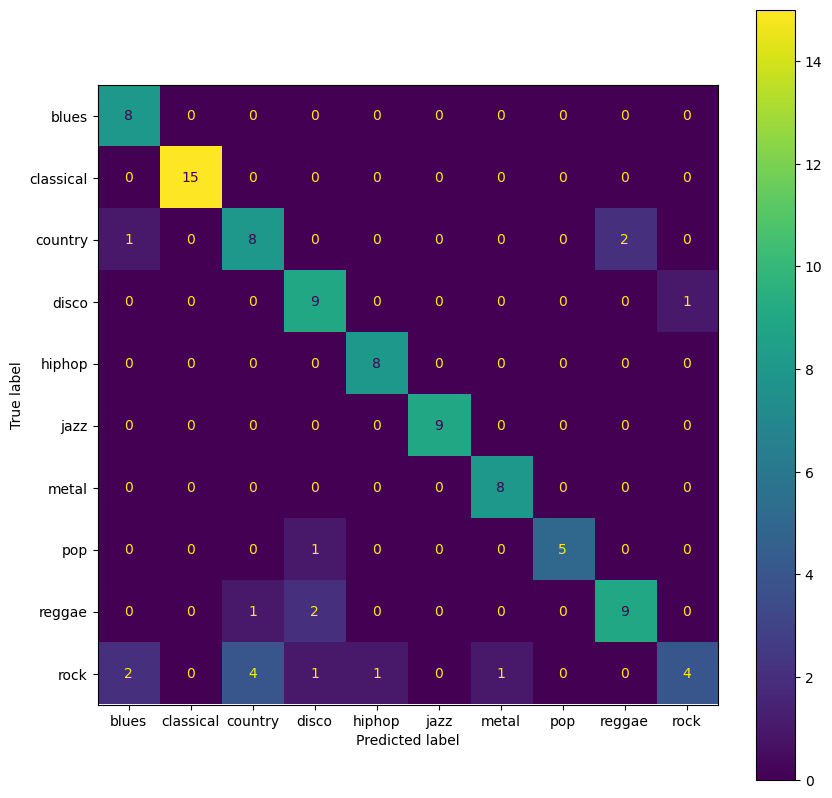

In [20]:
pred=trainer.predict(gtzan_encoded["test"].with_format("torch"))
print(pred.metrics)
confusion_matrix=metrics.confusion_matrix(pred.label_ids, np.argmax(pred.predictions, axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label2id.keys()))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
fig.savefig('images/Test_confusion_matrix.jpg')
plt.show()